In [3]:
#Scratch Model Classification
import zipfile
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import glob
from torch.autograd import Variable
from torchvision import models
from torch.nn import Module,  Linear, ReLU, CrossEntropyLoss, Sequential, Conv3d, MaxPool3d, Softmax, BatchNorm3d
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import seaborn as sn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from torchsummary import summary

%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
import os
#walk through directory and list through files
for dirpath, dirnames, filenames in os.walk("/content/drive/My Drive/ADNI_full"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
len(filenames)


There are 4 directories and 0 images in '/content/drive/My Drive/ADNI_full'.
There are 0 directories and 189 images in '/content/drive/My Drive/ADNI_full/AD'.
There are 0 directories and 220 images in '/content/drive/My Drive/ADNI_full/LMCI'.
There are 0 directories and 254 images in '/content/drive/My Drive/ADNI_full/CN'.
There are 0 directories and 0 images in '/content/drive/My Drive/ADNI_full/.ipynb_checkpoints'.


0

In [6]:
#Get the class names
import numpy as np
import pathlib
data_dir = pathlib.Path('/content/drive/My Drive/ADNI_full')
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['.ipynb_checkpoints' 'AD' 'CN' 'LMCI']


In [7]:

with open("/content/drive/MyDrive/Images_ADNI.txt", 'rb') as fp:
  X=pickle.load(fp)
  y=pickle.load(fp)

In [8]:
X.shape, y.shape

((663, 100, 100, 55, 1), (663,))

In [9]:
X = torch.from_numpy(X)
X.shape, X.dtype

(torch.Size([663, 100, 100, 55, 1]), torch.float32)

In [10]:
X=X.reshape(663,1,100,100,55)

X.shape

torch.Size([663, 1, 100, 100, 55])

In [11]:
X=X.expand(-1,3,-1,-1,-1)
X.shape

torch.Size([663, 3, 100, 100, 55])

In [12]:
y = torch.from_numpy(y)
y.shape, y.dtype

(torch.Size([663]), torch.int64)

In [13]:
from sklearn.model_selection import train_test_split
#batch_size=32
X_train,X_test_data, y_train,y_test_data =train_test_split(X,y, test_size=0.2,  random_state=42)
X_val,X_test,y_val,y_test= train_test_split(X_test_data,y_test_data, test_size=0.5,random_state=42)
#X_train, X_test, y_train, y_test,X_val,y_val = X_train.cuda(), X_test.cuda(), y_train.cuda(), y_test.cuda(),X_val.cuda(), y_val.cuda()

(X_train.shape, y_train.shape),(X_test.shape, y_test.shape),(X_val.shape,y_val.shape), (X_train.dtype, y_train.dtype)

((torch.Size([530, 3, 100, 100, 55]), torch.Size([530])),
 (torch.Size([67, 3, 100, 100, 55]), torch.Size([67])),
 (torch.Size([66, 3, 100, 100, 55]), torch.Size([66])),
 (torch.float32, torch.int64))

In [14]:
from torch.utils.data import DataLoader,TensorDataset
BATCH_SIZE = 10
dataset = TensorDataset(X_train, y_train)
dataset1= TensorDataset(X_val, y_val)
dataset2 = TensorDataset(X_test, y_test)


train_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader= DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader= DataLoader(dataset2,batch_size=BATCH_SIZE, shuffle=False)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [16]:
multiclass_resnet_scratch = models.video.r3d_18(pretrained=False, progress=False)

In [17]:
multiclass_resnet_scratch = multiclass_resnet_scratch.to(device)

In [18]:
summary(multiclass_resnet_scratch, (3, 100, 100,55))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 64, 100, 50, 28]          28,224
       BatchNorm3d-2      [-1, 64, 100, 50, 28]             128
              ReLU-3      [-1, 64, 100, 50, 28]               0
      Conv3DSimple-4      [-1, 64, 100, 50, 28]         110,592
       BatchNorm3d-5      [-1, 64, 100, 50, 28]             128
              ReLU-6      [-1, 64, 100, 50, 28]               0
      Conv3DSimple-7      [-1, 64, 100, 50, 28]         110,592
       BatchNorm3d-8      [-1, 64, 100, 50, 28]             128
              ReLU-9      [-1, 64, 100, 50, 28]               0
       BasicBlock-10      [-1, 64, 100, 50, 28]               0
     Conv3DSimple-11      [-1, 64, 100, 50, 28]         110,592
      BatchNorm3d-12      [-1, 64, 100, 50, 28]             128
             ReLU-13      [-1, 64, 100, 50, 28]               0
     Conv3DSimple-14      [-1, 64, 100,

In [20]:
multiclass_resnet_scratch

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [21]:
for param in multiclass_resnet_scratch.parameters():
    param.requires_grad = False

In [22]:
multiclass_resnet_scratch.fc =  nn.Sequential(
            nn.Linear(512, 512),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(512, 3),
            )
for param in multiclass_resnet_scratch.fc.parameters():
    param.requires_grad = True

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(multiclass_resnet_scratch.fc.parameters(), lr=0.001) 

In [24]:
summary(multiclass_resnet_scratch, (3, 100, 100,55))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 64, 100, 50, 28]          28,224
       BatchNorm3d-2      [-1, 64, 100, 50, 28]             128
              ReLU-3      [-1, 64, 100, 50, 28]               0
      Conv3DSimple-4      [-1, 64, 100, 50, 28]         110,592
       BatchNorm3d-5      [-1, 64, 100, 50, 28]             128
              ReLU-6      [-1, 64, 100, 50, 28]               0
      Conv3DSimple-7      [-1, 64, 100, 50, 28]         110,592
       BatchNorm3d-8      [-1, 64, 100, 50, 28]             128
              ReLU-9      [-1, 64, 100, 50, 28]               0
       BasicBlock-10      [-1, 64, 100, 50, 28]               0
     Conv3DSimple-11      [-1, 64, 100, 50, 28]         110,592
      BatchNorm3d-12      [-1, 64, 100, 50, 28]             128
             ReLU-13      [-1, 64, 100, 50, 28]               0
     Conv3DSimple-14      [-1, 64, 100,

# Training  Scratch Model 

In [25]:

torch.manual_seed(50)
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_dataloader):
        b+=1
        
        # Apply the model
        y_pred = multiclass_resnet_scratch(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/530]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_val, y_val) in enumerate(validation_dataloader):

            # Apply the model
            outputs = multiclass_resnet_scratch(X_val)

            # Tally the number of correct predictions
            predicted = torch.max(outputs.data, 1)[1] 
            tst_corr += (predicted == y_val).sum()
            
    loss = criterion(outputs, y_val)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed  


epoch:  0  batch:   10 [   100/530]  loss: 0.94140834  accuracy:  39.000%
epoch:  0  batch:   20 [   200/530]  loss: 1.11862075  accuracy:  41.500%
epoch:  0  batch:   30 [   300/530]  loss: 0.96418172  accuracy:  45.000%
epoch:  0  batch:   40 [   400/530]  loss: 1.00007451  accuracy:  44.750%
epoch:  0  batch:   50 [   500/530]  loss: 0.94020307  accuracy:  45.800%
epoch:  1  batch:   10 [   100/530]  loss: 1.01993620  accuracy:  55.000%
epoch:  1  batch:   20 [   200/530]  loss: 0.99085581  accuracy:  50.500%
epoch:  1  batch:   30 [   300/530]  loss: 0.79918694  accuracy:  55.333%
epoch:  1  batch:   40 [   400/530]  loss: 0.86545897  accuracy:  57.000%
epoch:  1  batch:   50 [   500/530]  loss: 0.77170759  accuracy:  60.000%
epoch:  2  batch:   10 [   100/530]  loss: 0.93665010  accuracy:  65.000%
epoch:  2  batch:   20 [   200/530]  loss: 0.86157322  accuracy:  67.500%
epoch:  2  batch:   30 [   300/530]  loss: 0.79008758  accuracy:  69.667%
epoch:  2  batch:   40 [   400/530]  l

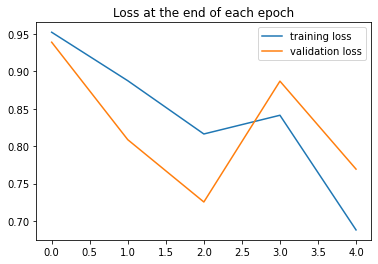

In [26]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();
#plt.savefig('model_resnet_losscurves.png')

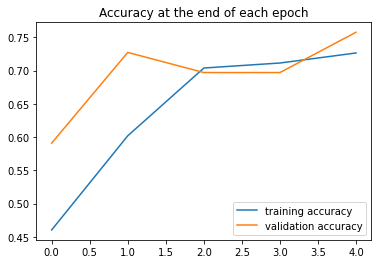

In [27]:
plt.plot([t/530 for t in train_correct], label='training accuracy')
plt.plot([t/66 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

# Evaluation of the Model

In [28]:
torch.manual_seed(53)
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_dataloader:
        y_val1 = multiclass_resnet_scratch(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val1,1)[1]
        correct += (predicted == y_test).sum()
print(f'Testing  accuracy: {correct.item()}/{len(dataset2)} = {correct.item()*100/(len(dataset2)):7.3f}%')

Testing  accuracy: 46/67 =  68.657%


In [29]:
torch.manual_seed(52)
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = multiclass_resnet_scratch(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy of the network on the 66 test images: {100 * correct // total} %')

Accuracy of the network on the 66 test images: 73 %


No handles with labels found to put in legend.


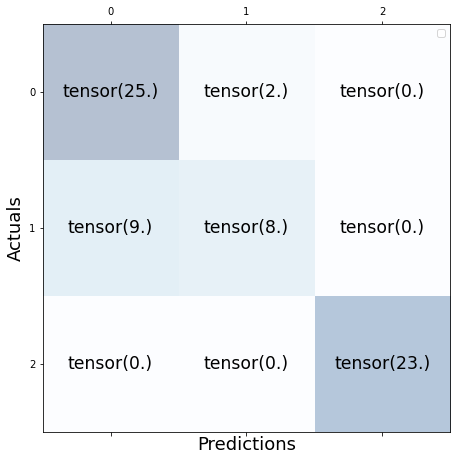

In [30]:
torch.manual_seed(51)
nb_classes = 3
from sklearn.metrics import confusion_matrix
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = multiclass_resnet_scratch(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confusion_matrix.shape[0]):
  for j in range(confusion_matrix.shape[1]):
    ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.legend()
plt.show();
#print(confusion_matrix)

In [37]:
torch.manual_seed(54)
# prepare to count predictions for each class
classes= ['CN','AD', 'LMCI']
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for X_test, y_test in test_dataloader:
        outputs = multiclass_resnet_scratch(X_test)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(y_test, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class CN    is: 88.9 %
Accuracy for class AD    is: 11.8 %
Accuracy for class LMCI  is: 100.0 %


In [32]:
torch.manual_seed(56)
y_pred_list = []
labels_list = []
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        batch_size = images.shape[0]
        # calculate outputs by running images through the network
        outputs = multiclass_resnet_scratch(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted=predicted.detach().numpy()
        labels=labels.detach().numpy()
        for i in range(batch_size):
          y_pred_list.append(predicted[i])
          labels_list.append(labels[i])

print(f'Accuracy of the network on the 67 test images: {100 * correct // total} %')
matthews_corrcoef(y_pred_list, labels_list) 


Accuracy of the network on the 67 test images: 73 %


0.5887147332235396

In [33]:
len(y_pred_list)

67

In [34]:
len(labels_list)

67

In [35]:
acc = accuracy_score(y_pred_list,labels_list)
print(acc)

0.7313432835820896


In [36]:
balanced_accuracy_score(y_pred_list,labels_list)


0.689709595959596

# Save the Model

In [38]:
filepath='Multiclass_scrach_eval.pt'
torch.save(multiclass_resnet_scratch.state_dict(), filepath)